In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1WlWMCJ9AHTHX9hkUN2ccAY8-ZI8Az2nC',
                                    dest_path='./train/train.zip',
                                    unzip=True)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.metrics import jaccard_score
from pathlib import Path

In [ ]:
df = pd.read_csv('names.csv')

In [ ]:
df

,Filenames
0,1555076042-aadhar-card_json
1,15702284b04c27864e819ad89483b80d_json
2,2020_11$largeimg_1346769636_json
3,20211019_170842_json
4,20211019_170857_json
...,...
60,CvwsYHqW8AARR5c_json
61,Feature-Image-4-1280x720_json
62,Handwritten_2021-10-19_173353_json
63,pvc_adhar-card_json


In [ ]:
from sklearn.model_selection import train_test_split
train_df,val_df= train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# !pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image

class MyDataset(Dataset):
    def __init__(self, df,img_dir,transform_image=None,transform_label=None):
        self.df=df
        self.img_dir=img_dir
        self.transform_image = transform_image
        self.transform_label = transform_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # device = 'cuda' if torch.cuda.is_available() else 'cpu'
        img_path =self.img_dir+'/'+self.df.iloc[idx,0]+'/'+'img.png'
        image = cv2.imread(img_path)
        image = cv2.resize(image,(256,256))
        image = image.transpose(2,0,1)
        image = torch.from_numpy(image.astype(np.float32))
        # image=image.to(device)
        if self.transform_image:
            image = self.transform_image(image)


        if self.img_dir=='train' :
            label_path =self.img_dir+'/'+self.df.iloc[idx,0]+'/'+'label.png'
            label = cv2.imread(label_path)
            label=cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
            label = cv2.resize(label,(256,256))
            label = np.where(label>0,1,0)
            label = torch.from_numpy(label.astype(np.float32))
            # label=label.to(device)
            if self.transform_label:
              label = self.transform_label(label)


        
        return image,label

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [ ]:
from torchvision import transforms
preprocess_image = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomGrayscale(p=0.1),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(2, p=0.5),
    # transforms.RandomRotation(degrees=180)
])
preprocess_label = transforms.Compose([
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomCrop(224),
    # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    # transforms.RandomGrayscale(p=0.1),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAdjustSharpness(2, p=0.5),
    # transforms.RandomRotation(degrees=180)
])

In [ ]:
from torch.utils.data import DataLoader

training_data=MyDataset(train_df,'train',preprocess_image,preprocess_label)
validation_data=MyDataset(val_df,'train',preprocess_image,preprocess_label)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

In [ ]:
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask
        print("here")
        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [ ]:
from torch.nn import functional as F
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):        
        
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        # print(inputs.shape)
        # inputs = inputs[inputs.shape.item()/2:]
        # print(inputs.shape)
        targets = targets.view(-1)
        inverse_targets = torch.where(targets==1,0,1)
        # intersection = (inputs * targets).sum()  
        intersection_inverse = (inputs * inverse_targets).sum() 
        # print(intersection)
        # print(intersection_inverse)                          
        # dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        # return 1 - dice
        return intersection_inverse

In [ ]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """

    true = true.to("cpu")
    pred = pred.to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [ ]:
!pip install pytorch_lightning
!pip install segmentation_models_pytorch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer,scheduler=None):
    size = len(dataloader.dataset)
    for batch,(image,label) in enumerate(dataloader):
        # Compute prediction and loss
        image=image.to(device)
        label=label.to(device)
        pred = model(image)
        # print(pred.shape)
        # print(label.shape)
        loss = loss_fn(pred[:,1,:,:], label.long())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
          scheduler.step()
        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(image)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for (image,label) in dataloader:
            image=image.to(device)
            label=label.to(device)
            pred = model(image)
            test_loss += loss_fn(pred[:,1,:,:], label.long()).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

In [ ]:
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
model=model.to(device)



In [ ]:
learning_rate = 1e-7
batch_size = 16
epochs = 250

In [ ]:
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)#,exp_lr_scheduler)
    val_loop(val_dataloader, model, loss_fn)
print("Done!\n")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 161801.062500  [    0/   52]
loss: 161699.953125  [   40/   52]
Avg loss: 132029.875000 

Epoch 2
-------------------------------
loss: 163219.921875  [    0/   52]
loss: 165641.593750  [   40/   52]
Avg loss: 132419.421875 

Epoch 3
-------------------------------
loss: 161579.593750  [    0/   52]
loss: 162545.406250  [   40/   52]
Avg loss: 131885.882812 

Epoch 4
-------------------------------
loss: 161482.671875  [    0/   52]
loss: 163054.906250  [   40/   52]
Avg loss: 132296.812500 

Epoch 5
-------------------------------
loss: 161390.046875  [    0/   52]
loss: 161043.187500  [   40/   52]
Avg loss: 132330.710938 

Epoch 6
-------------------------------
loss: 162240.296875  [    0/   52]
loss: 162684.937500  [   40/   52]
Avg loss: 131557.875000 

Epoch 7
-------------------------------
loss: 162291.140625  [    0/   52]
loss: 161972.703125  [   40/   52]
Avg loss: 132139.839844 

Epoch 8
-------------------------------
loss: 161017.109375  [    0/   52]
loss: 162377.

KeyboardInterrupt: ignored

In [ ]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
idx=6

In [ ]:
image_path ='train'+'/'+val_df.iloc[idx,0]+'/'+'img.png'
image = cv2.imread(image_path)
image = cv2.resize(image,(256,256))
image = image.transpose(2,0,1)
image = image.reshape(1,3,256,256)
image = torch.from_numpy(image.astype(np.float32))
image=image.to(device)
pred=model(image)
pred=pred.to('cpu')

In [ ]:
pred=pred.detach().numpy().reshape(2,256,256)
# plt.imshow(pred,cmap='gray')

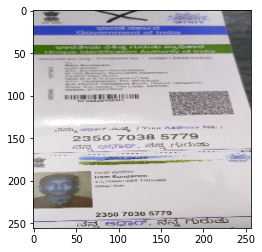

In [ ]:
image_path ='train'+'/'+val_df.iloc[idx,0]+'/'+'img.png'
image = cv2.imread(image_path)
image = cv2.resize(image,(256,256))
plt.imshow(image)

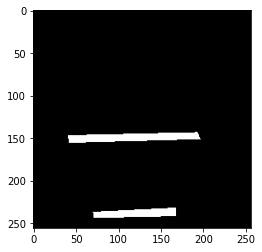

In [ ]:
label_path ='train'+'/'+val_df.iloc[idx,0]+'/'+'label.png'
label = cv2.imread(label_path)
label=cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
label = cv2.resize(label,(256,256))
label = np.where(label>0,1,0)
plt.imshow(label,cmap='gray')

In [ ]:
pred=np.where(pred>0,1,0)

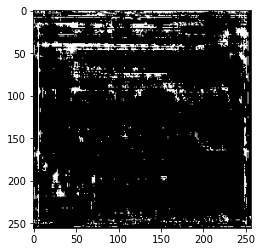

In [ ]:
plt.imshow(pred[1],cmap='gray')

In [ ]:
image_path ='train'+'/'+val_df.iloc[idx,0]+'/'+'img.png'
image = cv2.imread(image_path)
image = cv2.resize(image,(256,256))
count=0
for i in range(256):
  for j in range(256):
    if(pred[0,i,j]==1):
      count=count+1
      image[i,j,:3]=0

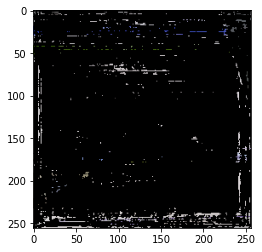

In [ ]:
plt.imshow(image)